## Getting started (Adjust settings to your experiment's needs)

In [2]:
import os
import sys
import logging
from beir import util
from beir.datasets.data_loader import GenericDataLoader
import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW
from ir_measures import nDCG, AP, P, R, RR
from IRutils import dataprocessor, models, train, inference
from IRutils.dataset import TripletRankingDataset
from transformers import AutoTokenizer

#################### THINGS TO CHANGE FOR YOUR EXPERIMENTS ####################

dataset_name = "scifact"  # SELECT YOUR EXPERIMENT DATASET HERE
model_name = "distilbert-base-uncased"  # SELECT YOUR MODEL HERE

# Create dataset for a specific query length range (e.g., short queries)
length_setting = 'full'

metrics = [nDCG@10, nDCG@100, AP@10, AP@100, P@10, R@10, P@100, R@100, RR]

#################### THINGS TO CHANGE FOR YOUR EXPERIMENTS ####################

logging.disable(logging.WARNING)

datasets = {'msmarco': ['train', 'dev'],
            'hotpotqa': ['train', 'dev', 'test'],
            'arguana': ['test'],
            'quora': ['dev', 'test'],
            'scidocs': ['test'],  # small
            'fever': ['train', 'dev', 'test'],  # large
            'climate-fever': ['test'],
            'scifact': ['train', 'test'],
            'fiqa': ['train', 'dev', 'test'],
            'nfcorpus': ['train', 'dev', 'test']
            }

max_len_doc = 512  # max token length
random_state = 42

c:\Users\eanto\OneDrive\Documents\dsait\quarter_3\information_retrieval\research\IRvenv\Lib\site-packages\beir\util.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm


In [3]:
# Download and unzip the dataset
data_path = f"./datasets/{dataset_name}"
if not os.path.exists(data_path):
    url = f"https://public.ukp.informatik.tu-darmstadt.de/thakur/BEIR/datasets/{dataset_name}.zip"
    data_path = util.download_and_unzip(url, "datasets")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

train_available = False
if 'train' in datasets[dataset_name]:
    # Load the dataset
    docs, queries, qrels = GenericDataLoader(data_folder=data_path).load(split="train")
    docs_test, queries_test, qrels_test = GenericDataLoader(data_folder=data_path).load(split="test")
    train_available = True
    print('Train and test set available!')
else:
    # Load the dataset
    docs, queries, qrels = GenericDataLoader(data_folder=data_path).load(split="test")
    print('Only test set available!')

  0%|          | 0/5183 [00:00<?, ?it/s]

  0%|          | 0/5183 [00:00<?, ?it/s]

Train and test set available!


In [4]:
# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name)

## Data visualization

In [5]:
import numpy as np

def calculate_percentiles(query_lengths):
    # Calculate the 25th, and 75th percentiles
    t1 = np.percentile(query_lengths, 25)
    t2 = np.percentile(query_lengths, 75)
    return int(t1), int(t2)

t1: 9
t2: 15


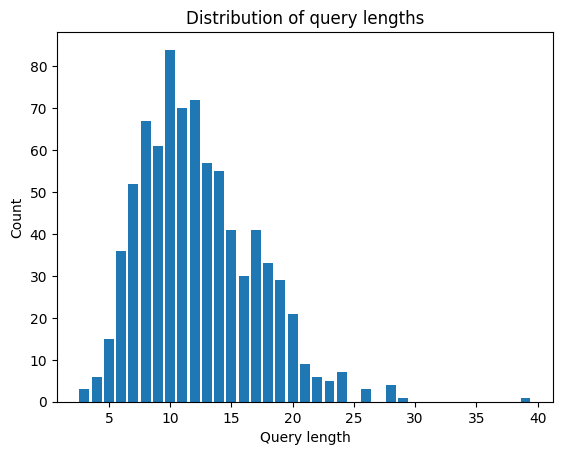

In [6]:
import matplotlib.pyplot as plt
from collections import Counter

query_lengths = [len(txt.split()) for txt in list(queries.values())]
t1, t2 = calculate_percentiles(query_lengths)
print(f't1: {t1}')
print(f't2: {t2}')
ranges = {'short': (1, t1), 'medium': (t1, t2), 'long': (t2, sys.maxsize), 'full': (1, sys.maxsize)}

counts = Counter(query_lengths)
text_lengths = list(set(query_lengths))

counts = [counts[length] for length in text_lengths]
# Create bar chart
plt.bar(text_lengths, counts)

# Add labels
plt.xlabel("Query length")
plt.ylabel("Count")
plt.title("Distribution of query lengths")

# Display plot
plt.show()


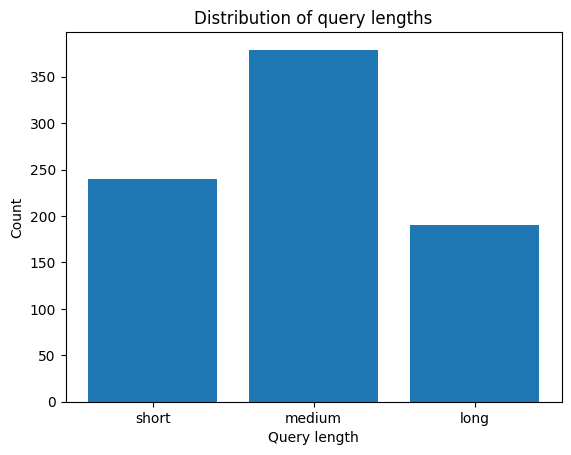

In [ ]:
short = {qid: q for qid, q in queries.items() if 1 <= len(q.split()) <= t1}
medium = {qid: q for qid, q in queries.items() if t1 <= len(q.split()) <= t2}
long = {qid: q for qid, q in queries.items() if t2 <= len(q.split())}

counts = [len(short), len(medium), len(long)]

# Create bar chart
plt.bar(list(ranges.keys())[:3], counts)

# Add labels
plt.xlabel("Query length")
plt.ylabel("Count")
plt.title("Distribution of query lengths")

# Display plot
plt.show()

### Get test split (if no seperate test set available)

In [8]:
dp = dataprocessor.DataProcessor(queries, docs, qrels)

print(f'Dataset size: {len(queries)}')

# first seperate the test set (include queries of all lengths)
if not train_available:
    query_test, qrel_test = dp.get_testset(test_ratio=0.2, random_state=random_state)
    test_dp = dataprocessor.DataProcessor(query_test, docs, qrel_test)
    if length_setting=='full':
        test_dp_short = dataprocessor.DataProcessor(query_test, docs, qrel_test)
        test_dp_medium = dataprocessor.DataProcessor(query_test, docs, qrel_test)
        test_dp_long = dataprocessor.DataProcessor(query_test, docs, qrel_test)
    print(f'test size: {len(query_test)}')
else:
    test_dp = dataprocessor.DataProcessor(queries_test, docs_test, qrels_test)
    if length_setting=='full':
        test_dp_short = dataprocessor.DataProcessor(queries_test, docs_test, qrels_test)
        test_dp_medium = dataprocessor.DataProcessor(queries_test, docs_test, qrels_test)
        test_dp_long = dataprocessor.DataProcessor(queries_test, docs_test, qrels_test)
    print(f'test size: {len(queries_test)}')

Dataset size: 809
test size: 300


### Query length filtering

In [9]:
# filter by query length
print(f'Length range: {ranges[length_setting]}')
query_subset, qrels_subset = dp.get_subset(ranges[length_setting][0], ranges[length_setting][1])  # Adjust min/max length

Length range: (1, 9223372036854775807)


In [10]:
# filter by query length
test_sets = {}
print(f'Length range: {ranges[length_setting]}')
test_sets[length_setting] = test_dp.get_subset(ranges[length_setting][0], ranges[length_setting][1])

if length_setting=='full':
    test_sets['short'] = test_dp_short.get_subset(ranges['short'][0], ranges['short'][1])
    test_sets['medium'] = test_dp_medium.get_subset(ranges['medium'][0], ranges['medium'][1])
    test_sets['long'] = test_dp_long.get_subset(ranges['long'][0], ranges['long'][1])

Length range: (1, 9223372036854775807)


### Train Val split

In [11]:
# print(f'Example query from {length_setting} subset:\n{query_subset.popitem()}')

query_train, query_val, qrel_train, qrel_val = dp.train_val_split(train_ratio=0.8, val_ratio=0.2, train_available=train_available, random_state=42)  # adjust if needed

print(f'Length of subset of {length_setting} validation queries: {len(query_val)}')
print(f'Length of subset of {length_setting} training queries: {len(query_train)}')
print(f'Length of subset of {length_setting} queries: {len(query_subset)}')

Length of subset of full validation queries: 162
Length of subset of full training queries: 647
Length of subset of full queries: 809


### Check if the qrels already contain negative samples （If not create later)

In [12]:
qrel_scores = list(qrels.values()) 
relevance_scores = [list(item.values()) for item in qrel_scores]
num_negatives = relevance_scores[0].count(0)
print(f'Number of negatives in qrels: {num_negatives}')

Number of negatives in qrels: 0


### Create datasets and data loaders

In [13]:
test = []
for key, value in qrels.items():
    test.append(len(value))

In [14]:
max(test)

5

In [15]:
print('Creating training dataset...')
train_dataset = TripletRankingDataset(query_train, docs, qrel_train, tokenizer, num_negatives, max_length=max_len_doc, neg_sample_size=5)
train_loader = DataLoader(train_dataset, batch_size=24, shuffle=True)

print('Creating validation dataset...')
val_dataset = TripletRankingDataset(query_val, docs, qrel_val, tokenizer, num_negatives,max_length=max_len_doc, neg_sample_size=5)
val_loader = DataLoader(val_dataset, batch_size=24, shuffle=True)

Creating training dataset...


100%|██████████| 647/647 [00:00<00:00, 4198.58it/s]


Creating validation dataset...


100%|██████████| 162/162 [00:00<00:00, 4119.07it/s]


In [16]:
print('Creating testing dataset...')
for l_setting, test_set in test_sets.items():
    queries_test = test_set[0]
    qrels_test = test_set[1]
    if train_available:
        test_dataset = TripletRankingDataset(queries_test, docs_test, qrels_test, tokenizer, num_negatives,max_length=max_len_doc, neg_sample_size=5)
        test_loader = DataLoader(test_dataset, batch_size=24, shuffle=True)
    else:
        test_dataset = TripletRankingDataset(queries_test, docs, qrels_test, tokenizer, num_negatives,max_length=max_len_doc, neg_sample_size=5) 
        test_loader = DataLoader(test_dataset, batch_size=24, shuffle=True)
    test_sets[l_setting] = [queries_test, qrels_test, test_loader]

Creating testing dataset...


100%|██████████| 85/85 [00:00<00:00, 4073.35it/s]


### Initialize model

In [17]:
# Initialize model and optimizer
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = models.TripletRankerModel(model_name).to(device)
optimizer = AdamW(model.parameters(), lr=2e-5)
model_path = os.path.join(os.getcwd(), f'models/{model_name}+{dataset_name}+{length_setting}_queries.pth')

### Train model (load directly if already trained)

In [18]:
if os.path.isfile(model_path):
    model.load_state_dict(torch.load(model_path, map_location=device))
else:
    # Train the model
    model = train.train_triplet_ranker(model, train_loader, val_loader, optimizer, device, model_path, epochs=10)

## Run inference on test set & write results on output

In [ ]:
# Example usage (replace with your data and model)
for l_setting, test_set in test_sets.items():
    qrels_test = test_set[1]
    test_loader = test_set[2]
    print(f"\nEvaluating {length_setting} model on {l_setting} test dataset ({len(qrels_test)} samples)")
    if train_available:
        metric_scores = inference.evaluate(model, test_loader, device, qrels_test)
    else:
        metric_scores = inference.evaluate(model, test_loader, device, qrels_test)
        
    for metric in metrics:
        print(f'Metric {metric} score: {metric_scores[metric]:.4f}')

    # Save results to a file
    with open(f"results/{model_name}+{dataset_name}+{length_setting}+evaluation+{l_setting}_queries.txt", "w") as f:
        f.write(f"Evaluation Results for {model_name} model finetuned on {length_setting} queries from {dataset_name} dataset:\n")
        f.write(f"normalized Discounted Cumulative Gain@10: {metric_scores[nDCG@10]:.4f}\n")
        f.write(f"normalized Discounted Cumulative Gain@100: {metric_scores[nDCG@100]:.4f}\n")
        f.write(f"\n")
        f.write(f"[Mean] Average Precision@10: {metric_scores[AP@10]:.4f}\n")
        f.write(f"[Mean] Average Precision@100: {metric_scores[AP@100]:.4f}\n")
        f.write(f"\n")
        f.write(f"Precision@10: {metric_scores[P@10]:.4f}\n")
        f.write(f"Recall@10: {metric_scores[R@10]:.4f}\n")
        f.write(f"\n")
        f.write(f"Precision@100: {metric_scores[P@100]:.4f}\n")
        f.write(f"Recall@100: {metric_scores[R@100]:.4f}\n")
        f.write(f"\n")
        f.write(f"[Mean] Reciprocal Rank: {metric_scores[RR]:.4f}\n")
        f.write(f"\n")
        f.write(f"----------------------------------------------------\n")
        f.write(f"\n")
        f.write(f"Explanation of metrics:\n")
        f.write(f"NDCG@k (Normalized Discounted Cumulative Gain: Ranking Quality | Prioritizes highly relevant documents appearing earlier in the ranking.\n")
        f.write(f"MAP (Mean Average Precision): Overall Relevance | Measures ranking precision across all relevant documents. Best for small-scale retrieval tasks.\n")
        f.write(f"Precision@k: Relevance | Measures how many of the top-k documents are relevant. Works well in precision-sensitive applications.\n")
        f.write(f"Recall@k: Coverage | Measures how many relevant documents appear in the top-k results. Important in recall-sensitive tasks.\n")
        f.write(f"MRR (Mean Reciprocal Rank): Single Relevant Result | Focuses on ranking the first relevant document. Good for QA tasks.\n")


Evaluating full model on full test dataset (300) samples


Evaluating: 100%|██████████| 71/71 [00:48<00:00,  1.45it/s]


Metric nDCG@10 score: 0.9006
Metric nDCG@100 score: 0.9026
Metric AP@10 score: 0.8676
Metric AP@100 score: 0.8685
Metric P@10 score: 0.1113
Metric R@10 score: 0.9947
Metric P@100 score: 0.0113
Metric R@100 score: 1.0000
Metric RR score: 0.8723

Evaluating full model on short test dataset (92) samples


Evaluating: 100%|██████████| 22/22 [00:15<00:00,  1.45it/s]


Metric nDCG@10 score: 0.9154
Metric nDCG@100 score: 0.9154
Metric AP@10 score: 0.8857
Metric AP@100 score: 0.8857
Metric P@10 score: 0.1141
Metric R@10 score: 1.0000
Metric P@100 score: 0.0114
Metric R@100 score: 1.0000
Metric RR score: 0.8877

Evaluating full model on medium test dataset (162) samples


Evaluating: 100%|██████████| 37/37 [00:25<00:00,  1.44it/s]


Metric nDCG@10 score: 0.9048
Metric nDCG@100 score: 0.9069
Metric AP@10 score: 0.8741
Metric AP@100 score: 0.8749
Metric P@10 score: 0.1074
Metric R@10 score: 0.9938
Metric P@100 score: 0.0109
Metric R@100 score: 1.0000
Metric RR score: 0.8758

Evaluating full model on long test dataset (85) samples


Evaluating: 100%|██████████| 22/22 [00:14<00:00,  1.47it/s]

Metric nDCG@10 score: 0.8909
Metric nDCG@100 score: 0.8939
Metric AP@10 score: 0.8533
Metric AP@100 score: 0.8552
Metric P@10 score: 0.1165
Metric R@10 score: 0.9929
Metric P@100 score: 0.0120
Metric R@100 score: 1.0000
Metric RR score: 0.8639
